<a href="https://colab.research.google.com/github/zosiak00/uczenie_maszynowe_ZK/blob/case1/Koziczak_case1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_validate, learning_curve, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, accuracy_score,  classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
import lightgbm as lgb

import os

Wczytanie danych:

In [3]:
ds = pd.read_csv('/content/drive/MyDrive/UEP/ML w finansach/case1.csv', delimiter=";", index_col=[0])
ds.drop(columns=['Index', 'Address'], inplace=True)

Sprawdzanie jak wyglądają dane:

In [ ]:
print(ds.shape)
ds.sample(3)

(9841, 48)


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
1071,0,19.62,0.00,58.85,3,1,0,1,3,101.000,101.0,101.000000,0.129187,51.493024,33.665988,0.0,0.0,0.0,4,100.997965,101.000000,0.0,0.002035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
7902,1,0.00,0.00,0.00,0,0,0,0,0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7376,0,38.72,19405.13,116663.08,6,6,0,4,6,0.005,49.0,10.328948,0.004160,48.999580,10.328430,0.0,0.0,0.0,12,61.970580,61.973688,0.0,0.003108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [ ]:
display(ds.describe())


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9.841000e+03,9.841000e+03,9841.000000,9.841000e+03,9012.000000,9.012000e+03,9.012000e+03,9012.000000,9012.000000,9012.000000,9012.000000,9012.000000,9012.0,9012.0,9012.0,9012.0,9012.000000,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.000000,9012.000000
mean,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,163.700945,3.729702,30.360939,25.840159,43.845153,523.152481,100.711721,4.800090,314.617297,44.755731,0.000003,0.000008,0.000005,283.362362,1.016092e+04,1.163832e+04,0.000008,1.477395e+03,36.255659,1.296207e+08,1.386849e+07,110.939207,5.638038,7.598535,0.003440,4.901909,0.0,0.0,0.0,0.0,485.614688,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.384931,4.826676
std,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,940.836550,141.445583,298.621112,263.820410,325.929139,13008.821539,2885.002236,138.609682,6629.212643,239.080215,0.000225,0.000516,0.000323,1352.404013,3.583227e+05,3.642048e+05,0.000516,2.424254e+05,447.528908,1.053858e+10,1.180390e+09,6128.634953,105.252500,81.818470,0.065698,17.246576,0.0,0.0,0.0,0.0,16883.278712,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.735121,16.678607
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.560535e+07,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,0.000000,1.000000,1.000000,0.001000,1.000000,0.426905,0.000000,0.164577,0.086184,0.000000,0.000000,0.000000,4.000000,2.262059e-01,2.670424e+00,0.000000,6.214900e-04,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,0.000000,17.340000,509.770000,4.663703e+04,3.000000,4.000000,0.000000,2.000000,2.000000,0.095856,6.000000,1.729730,0.049126,4.999380,1.606000,0.000000,0.000000,0.000000,8.000000,1.248680e+01,3.052963e+01,0.000000,1.722000e-03,1.000000,1.000000e-12,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,0.000000,565.470000,5480.390000,3.040710e+05,11.000000,27.000000,0.000000,5.000000,3.000000,2.000000,67.067040,22.000000,0.998800,61.520653,21.999380,0.000

Sprawdzenie ile jest braków danych:

In [ ]:
display(ds.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9841 entries, 0 to 9840
Data columns (total 48 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841

None

Badanie zmiennych kategorycznych:

In [ ]:
display(np.unique(ds['ERC20 most sent token type'].astype(str)))
display(np.unique(ds['ERC20_most_rec_token_type'].astype(str)))

In [ ]:
token_types = ds['ERC20 most sent token type'].astype(str)
uniq_values, uniq_idx, counts = np.unique(token_types.to_numpy(), return_index=True, return_counts=True)
non_unique_ERC20_idx = uniq_idx[counts > 1]
print("liczba nieunikatowych wartości zmiennej 'ERC20 most sent token type': {}".format(len(non_unique_ERC20_idx)), end='\n\n')


liczba nieunikatowych wartości zmiennej 'ERC20 most sent token type': 126



In [ ]:
token_types = ds['ERC20_most_rec_token_type'].astype(str)
uniq_values, uniq_idx, counts = np.unique(token_types.to_numpy(), return_index=True, return_counts=True)
non_unique_ERC20_idx = uniq_idx[counts > 1]
print("liczba nieunikatowych wartości zmiennej 'ERC20_most_rec_token_type': {}".format(len(non_unique_ERC20_idx)), end='\n\n')


liczba nieunikatowych wartości zmiennej 'ERC20_most_rec_token_type': 188



Zmienne kategoryczne 'ERC20 most sent token type' oraz 'ERC20_most_rec_token_type' zawierają informacje o tokenach, które w większości przyjmują wartości unikatowe, w związku z czym można przyjąć założenie, że nie będą one wpływały na wykrywanie przestępstw, dlatego zostaną usunięte.

In [4]:
ds.drop(columns=['ERC20 most sent token type', 'ERC20_most_rec_token_type'], inplace=True)

Sprawdzenie czy dane są zbilansowane:

klasa : liczebność : odsetek
0     : 7662  : 77.86%
1     : 2179  : 22.14%


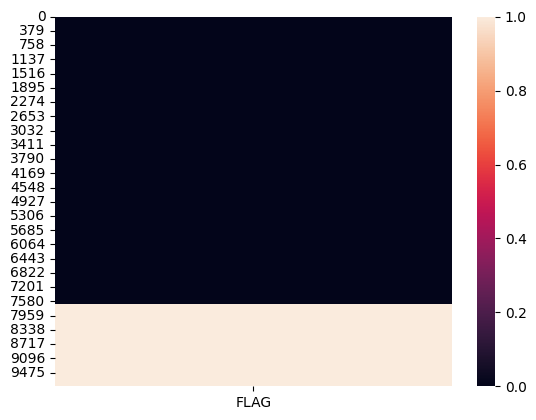

In [ ]:
print('klasa : liczebność : odsetek')
print('0     : {}  : {:.2%}'.format(sum(ds['FLAG']==0), sum(ds['FLAG']==0)/len(ds['FLAG']) ))
print('1     : {}  : {:.2%}'.format(sum(ds['FLAG']==1), sum(ds['FLAG']==1)/len(ds['FLAG']) ))

sns.heatmap(ds.iloc[:,:1])
plt.show()

Wniosek: dane nie są zbilansowane

Usuwanie niepotrzbnych kolumn (zawierających tylko zera lub NaN):

In [5]:
columns_with_zeros_and_nan = []
for column in ds.columns:
    if ds[column].isnull().any() and (ds[column] == 0).any():
        columns_with_zeros_and_nan.append(column)

print("Kolumny zawierające zarówno zera, jak i NaN:")
for column in columns_with_zeros_and_nan:
    print(column)

Kolumny zawierające zarówno zera, jak i NaN:
Total ERC20 tnxs
ERC20 total Ether received
ERC20 total ether sent
ERC20 total Ether sent contract
ERC20 uniq sent addr
ERC20 uniq rec addr
ERC20 uniq sent addr.1
ERC20 uniq rec contract addr
ERC20 avg time between sent tnx
ERC20 avg time between rec tnx
ERC20 avg time between rec 2 tnx
ERC20 avg time between contract tnx
ERC20 min val rec
ERC20 max val rec
ERC20 avg val rec
ERC20 min val sent
ERC20 max val sent
ERC20 avg val sent
ERC20 min val sent contract
ERC20 max val sent contract
ERC20 avg val sent contract
ERC20 uniq sent token name
ERC20 uniq rec token name


In [6]:
ds_cleaned = ds.drop(columns=columns_with_zeros_and_nan)
print(ds_cleaned.shape)

(9841, 23)


Liczba zmiennych została zredukowana z 48 do 23

Sprawdzenie braków danych:

,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 total ether sent,ERC20 uniq rec token name,Avg min between sent tnx,avg val received,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,min val sent,total ether balance,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,FLAG
count,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
percent,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,8.423941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


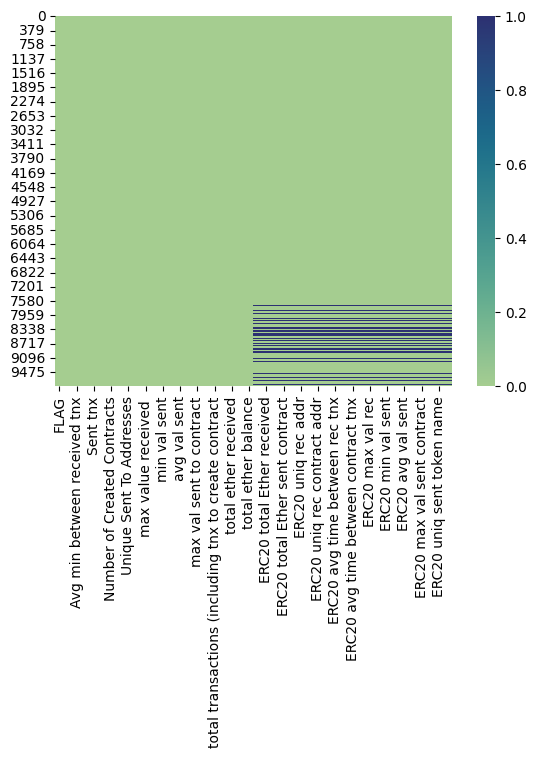

In [9]:
missing_values = ds.isna()
missing_percent = missing_values.sum() / ds.shape[0] * 100
missing_df = pd.DataFrame([missing_values.sum(), missing_percent], ['count', 'percent'])
display(missing_df.sort_values(by='percent', axis=1, ascending=False))
sns.heatmap(missing_values, cbar=True, cmap="crest")
plt.show()

In [ ]:
nieoszustwa, oszustwa = np.where( [ds.iloc[:,0]==1] )
print(ds.iloc[oszustwa,:].isna().sum()[-20:])

ERC20 total Ether sent contract        829
ERC20 uniq sent addr                   829
ERC20 uniq rec addr                    829
ERC20 uniq sent addr.1                 829
ERC20 uniq rec contract addr           829
ERC20 avg time between sent tnx        829
ERC20 avg time between rec tnx         829
ERC20 avg time between rec 2 tnx       829
ERC20 avg time between contract tnx    829
ERC20 min val rec                      829
ERC20 max val rec                      829
ERC20 avg val rec                      829
ERC20 min val sent                     829
ERC20 max val sent                     829
ERC20 avg val sent                     829
ERC20 min val sent contract            829
ERC20 max val sent contract            829
ERC20 avg val sent contract            829
ERC20 uniq sent token name             829
ERC20 uniq rec token name              829
dtype: int64


In [ ]:
missing_columns = ds.columns[ds.isna().sum() > 0]
print(missing_columns)

Index(['Total ERC20 tnxs', 'ERC20 total Ether received',
       'ERC20 total ether sent', 'ERC20 total Ether sent contract',
       'ERC20 uniq sent addr', 'ERC20 uniq rec addr', 'ERC20 uniq sent addr.1',
       'ERC20 uniq rec contract addr', 'ERC20 avg time between sent tnx',
       'ERC20 avg time between rec tnx', 'ERC20 avg time between rec 2 tnx',
       'ERC20 avg time between contract tnx', 'ERC20 min val rec',
       'ERC20 max val rec', 'ERC20 avg val rec', 'ERC20 min val sent',
       'ERC20 max val sent', 'ERC20 avg val sent',
       'ERC20 min val sent contract', 'ERC20 max val sent contract',
       'ERC20 avg val sent contract', 'ERC20 uniq sent token name',
       'ERC20 uniq rec token name'],
      dtype='object')


Jak widać, braki danych są mocno związane z wystąpieniem oszustwa

<ipython-input-50-defd162d0208>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = ds_cleaned.corr()


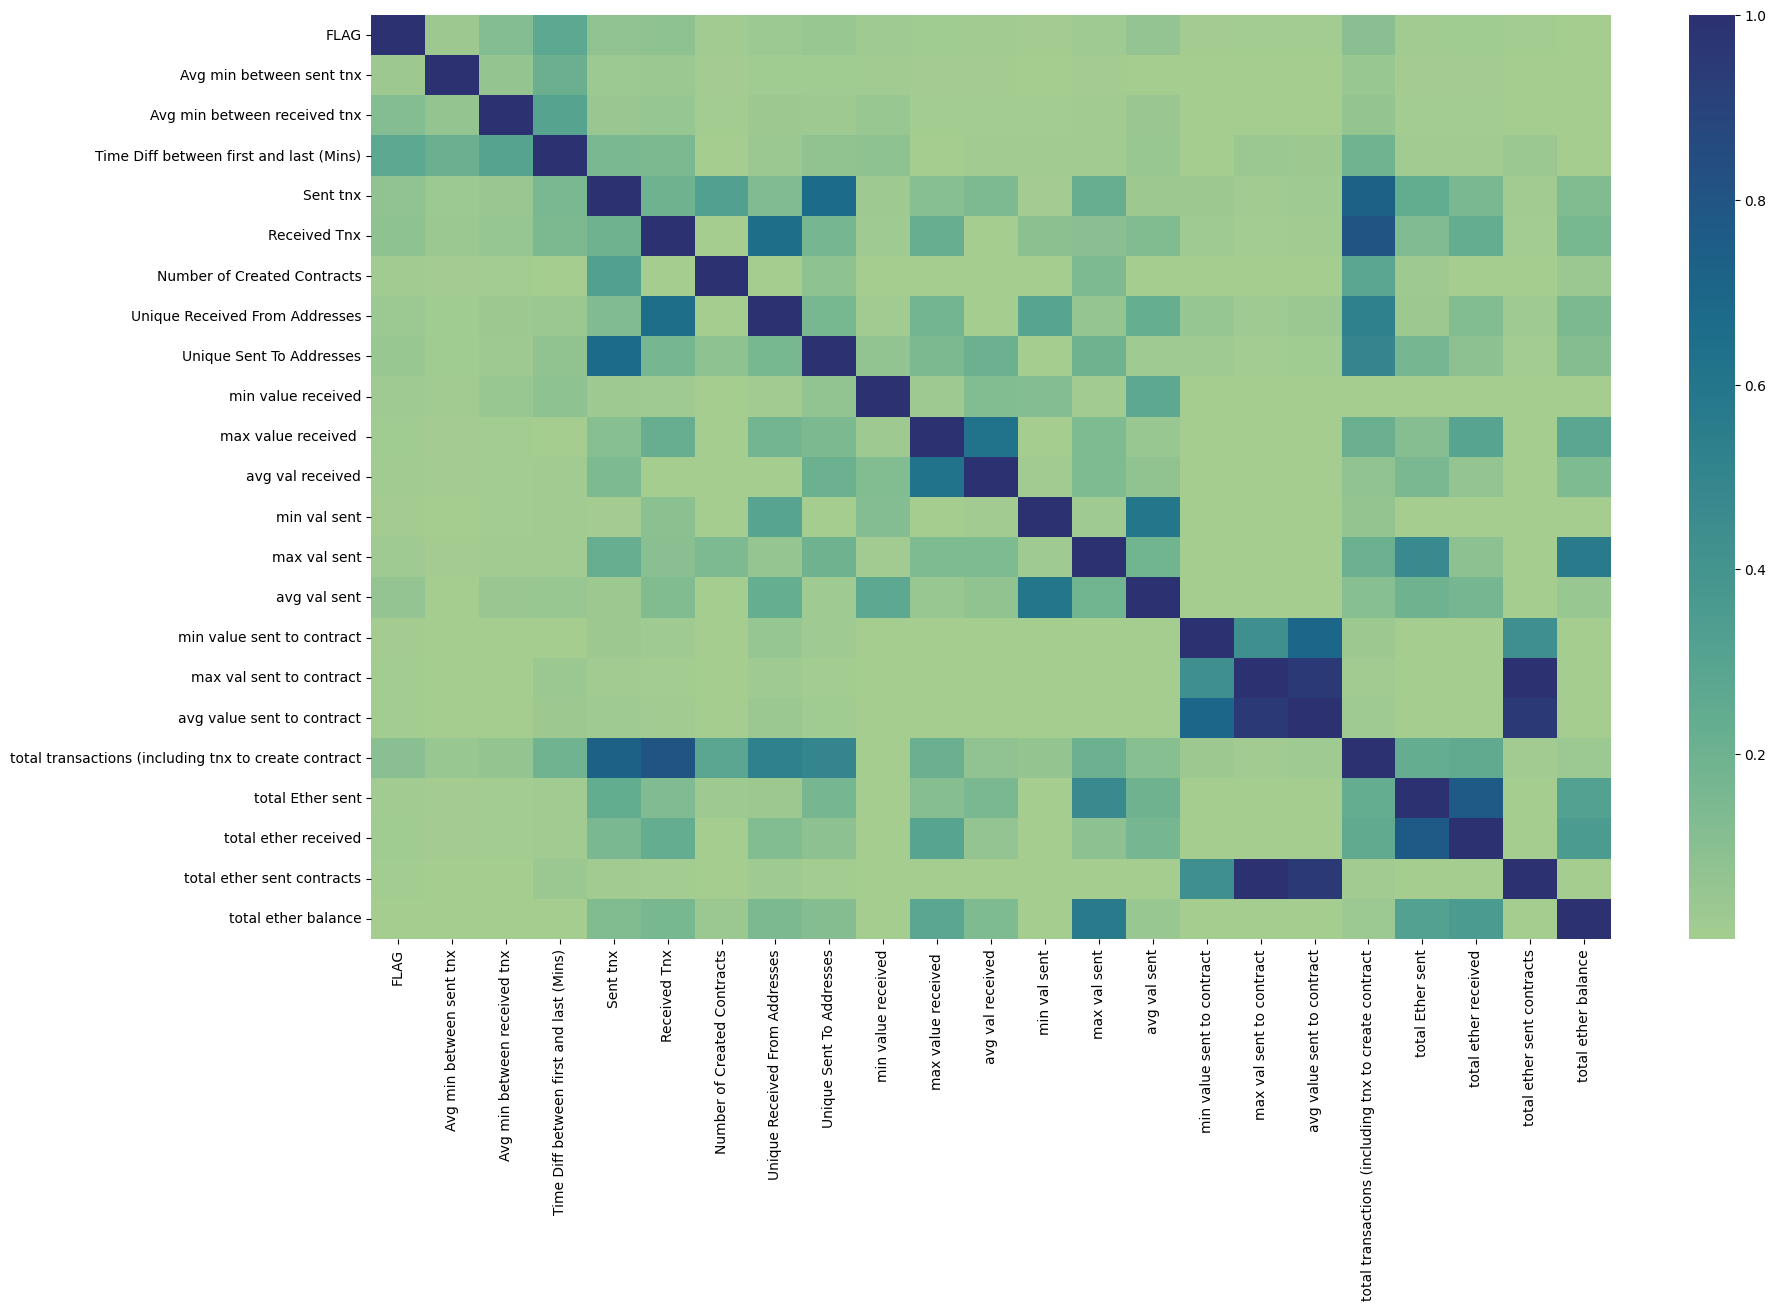

In [ ]:
corr = ds_cleaned.corr()
plt.figure(figsize=(20,12))
sns.heatmap(np.abs(corr), cmap='crest')
plt.show()

Przygotowanie danych numerycznych:

In [17]:
preprocessing_pipeline = Pipeline([
    ('impoter', SimpleImputer(strategy='mean')), # zastąpienie braków danych średnią
    ('scaler', StandardScaler()) # standaryzacja zmiennych tak, że mają średnią równą 0 i wariancję równą 1
])

X = ds.drop(columns='FLAG').to_numpy()
y = ds['FLAG'].to_numpy()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train = preprocessing_pipeline.fit_transform(X_train)
X_test = preprocessing_pipeline.transform(X_test)

Bilansowanie próbki:

In [28]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='auto')
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

Budowa modeli:

In [19]:
def oceny_modelu(X, y, models, cv):
    f1_scores = dict()
    dokladnosc = dict()

    for i, model in enumerate(models):
        clf_pipeline = make_pipeline(preprocessing_pipeline, model)
        results = cross_validate(clf_pipeline, X, y, cv=cv, scoring=['f1', 'accuracy'], n_jobs=-1)
        avg_f1 = np.mean(results['test_f1'])
        avg_dok = np.mean(results['test_accuracy'])

        model_name = model.__class__.__name__
        f1_scores[model_name] = avg_f1
        dokladnosc[model_name] = avg_dok
        print('{}-of-{}: {} f1={}, acc={}'.format(i+1, len(models), model_name, avg_f1, avg_dok))
    return f1_scores, dokladnosc

In [20]:
cv = StratifiedKFold(5, shuffle=True, random_state=42)

classifiers = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=42),
    lgb.LGBMClassifier(random_state=42),
    xgb.XGBClassifier(random_state=42),
    SVC(random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    MLPClassifier(random_state=42),
]

In [14]:
f1_scores, dokladnosc = oceny_modelu(X, y, classifiers, cv)

1-of-9: LogisticRegression f1=0.0, acc=0.7780713353730795
2-of-9: KNeighborsClassifier f1=0.7923342102875022, acc=0.9117977017759005
3-of-9: RandomForestClassifier f1=0.8656603182883289, acc=0.943705535392073
4-of-9: LGBMClassifier f1=0.8969388336957399, acc=0.95589890250096
5-of-9: XGBClassifier f1=0.8937642322441871, acc=0.954172034419684
6-of-9: SVC f1=0.01718913424416284, acc=0.7795955707779527
7-of-9: AdaBoostClassifier f1=0.8354836495780734, acc=0.9298855326669061
8-of-9: GaussianNB f1=0.38581076771441214, acc=0.30108872482833515
9-of-9: MLPClassifier f1=0.7488931930689726, acc=0.8786722656459677


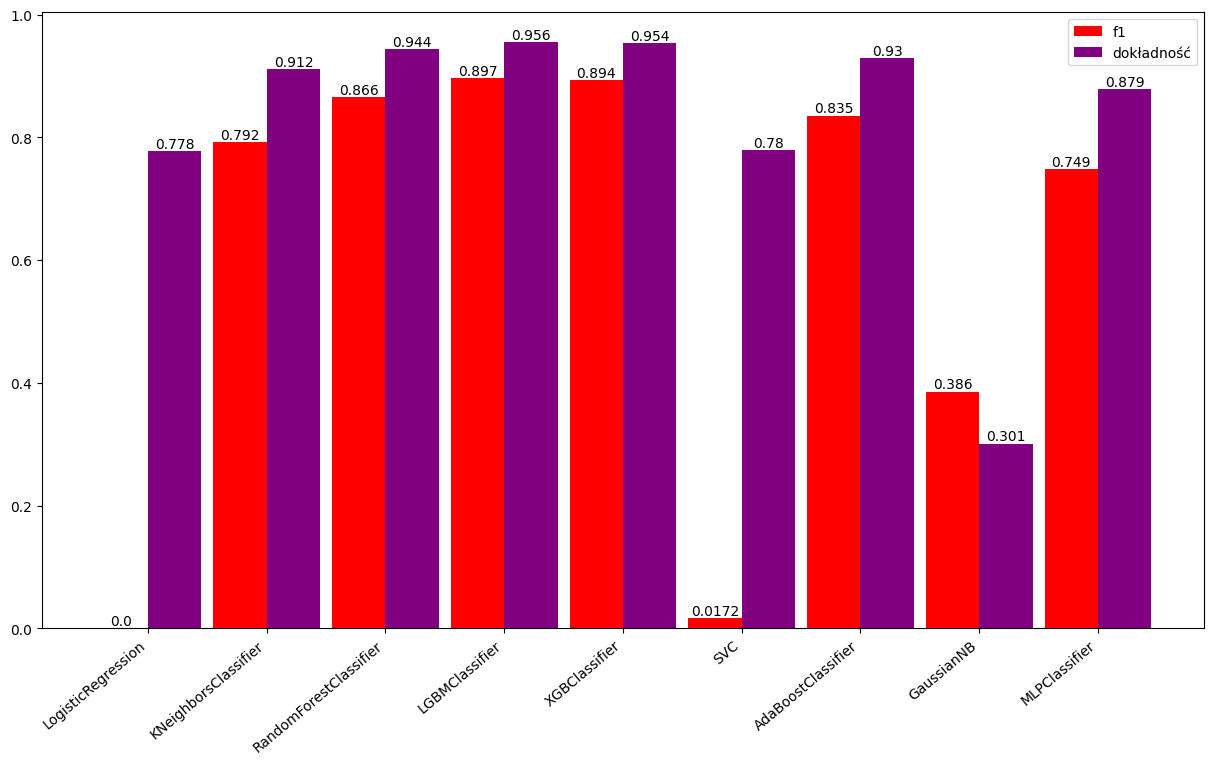

In [21]:
def wykres_ocen_modeli(f1_scores, dokladnosc):
    x = np.arange(len(f1_scores))
    width = 0.45

    f1_values = list(f1_scores.values())
    dokladnosc_values = list(dokladnosc.values())

    plt.figure(figsize=(15, 8)).tight_layout()
    plt.bar(x - width / 2, f1_values, width, label='f1', color='red')
    plt.bar(x + width / 2, dokladnosc_values, width, label='dokładność', color='purple')

    for index, value in enumerate(x - width / 2):
        plt.text(value, f1_values[index], '{:.3}'.format(f1_values[index]),
                 verticalalignment='bottom', horizontalalignment='center', fontsize=10)

    for index, value in enumerate(x + width / 2):
        plt.text(value, dokladnosc_values[index], '{:.3}'.format(dokladnosc_values[index]),
                 verticalalignment='bottom', horizontalalignment='center', fontsize=10)

    classifiers_names = f1_scores.keys()
    plt.xticks(x, classifiers_names, rotation=40, horizontalalignment='right', fontsize=10)
    plt.legend()

wykres_ocen_modeli(f1_scores, dokladnosc)

Na podstawie powyższego wykresu można stwierdzić, że najlepiej pod kątem dokładnosci i f2-score wypadły metody XGBoost, LGBMC oraz Las Losowy.
W kolejnej części notatnika zostanie przeprowadzona optymalizacja parametrów tych trzech metod.

Hiperparametryzacja dla metody XGBoost:

In [22]:
def ConfusionMatrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_names = ['Brak', 'Oszustwo']
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=0.8, style="whitegrid", palette="pastel")
    sns.heatmap(cm, annot=True, fmt="d", cmap="GnBu", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Przewidywane')
    plt.ylabel('Rzeczywiste')
    plt.title('Macierz pomyłek')
    plt.show()

In [23]:
# Funkcja do wyświetlania macierzy pomyłek:
def formatuj_macierz (y_test, y_pred):
  class_rep = classification_report(y_test, y_pred)
  class_names = ['Brak', 'Oszustwo']
  print("Wynik klasyfikacji:")
  print(tabulate([[''] * (len(class_names) + 1)] + [[class_names[i]] + values.split()[-3:] for i, values in enumerate(class_rep.split('\n')[2:-5])], headers=['Klasa', 'Precyzja', 'Czułość', 'F1-score'], tablefmt='grid'))

In [ ]:
# szukanie optymalnej konfiguracji hiperparametrów dla klasyfikatora XGBoost w celu uzyskania jak najlepszego wyniku na zbiorze testowym
clf = XGBClassifier(
    objective= 'binary:logistic',
    seed=42
)
params = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(1000,1500,100),
    'learning_rate': [0.1, 0.01, 0.05]
}
tuned_clf = GridSearchCV(estimator=clf,
                         param_grid=params,
                         scoring='f1',
                         cv=5,
                         verbose=2,
                         )

tuned_clf.fit(X_train_resampled,y_train_resampled)



Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   1.3s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=  11.7s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   6.5s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   1.3s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   1.3s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   1.5s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   1.5s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   1.4s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   1.5s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   8.4s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1200; total time=   1.6s
[CV] END ..learning_rate=0.1, max_depth=2, n_e

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(1000, 1500, 100)},
             scoring='f1', verbose=2)

In [ ]:
print("Tuned Hyperparameters :", tuned_clf.best_params_)
print("Train F1 Score :",tuned_clf.best_score_)
best_y_pred_XGB = tuned_clf.predict(X_test)
print('Test F1 Score: ', f1_score(y_test, best_y_pred_XGB))

Tuned Hyperparameters : {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1300}
Train F1 Score : 0.9705870528445708
Test F1 Score:  0.9651162790697674


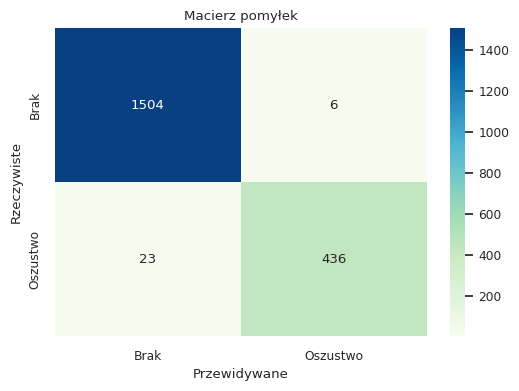

Wynik klasyfikacji:
+----------+------------+-----------+------------+
| Klasa    | Precyzja   | Czułość   |   F1-score |
+==========+============+===========+============+
|          |            |           |            |
+----------+------------+-----------+------------+
| Brak     | 1.00       | 0.99      |       1510 |
+----------+------------+-----------+------------+
| Oszustwo | 0.95       | 0.97      |        459 |
+----------+------------+-----------+------------+


In [46]:
from tabulate import tabulate

clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)

clf.fit(X_train_resampled, y_train_resampled)
y_pred_XGB = tuned_clf.predict(X_test)
class_names = ['Brak', 'Oszustwo']
ConfusionMatrix(y_test, y_pred_XGB)
formatuj_macierz(y_test, y_pred_XGB)


Hiperparametryzacja dla modelu **LightGBM**:

In [ ]:
LGBM_parameters = {
        'lgbmclassifier__bagging_fraction': [0, 0.2, 0.5, 0.8, 1],
        'lgbmclassifier__feature_fraction': [0.5, 0.8],
        'lgbmclassifier__max_depth': [6, 10, 13, 16, 20],
        'lgbmclassifier__min_data_in_leaf': range(40, 180, 20),
        'lgbmclassifier__num_leaves': range(500, 2500, 300)
}

LGBM_pipeline = make_pipeline(preprocessing_pipeline, lgb.LGBMClassifier(random_state=42))
LGBM_grid_search = RandomizedSearchCV(
    LGBM_pipeline,
    param_distributions=LGBM_parameters,
    scoring = 'f1',
    n_iter = 60,
    n_jobs = -1,
    cv = 5,
    random_state=42
)

LGBM_grid_search.fit(X, y)

In [ ]:
display(LGBM_grid_search.best_score_)
display(LGBM_grid_search.best_params_)

0.9732468344817388

{'lgbmclassifier__num_leaves': 2000,
 'lgbmclassifier__min_data_in_leaf': 160,
 'lgbmclassifier__max_depth': 10,
 'lgbmclassifier__feature_fraction': 0.8,
 'lgbmclassifier__bagging_fraction': 1}

Hiperparametryzacja dla modelu **RFC** (Random Forest Classifier):

In [26]:
RFC_parameters = {
        'randomforestclassifier__n_estimators': range(50, 1050, 100),
        'randomforestclassifier__max_depth': range(50, 300, 20),
        'randomforestclassifier__min_samples_split': [2, 5, 10],
        'randomforestclassifier__min_samples_leaf': [1, 2, 4],
        'randomforestclassifier__bootstrap': [True, False]
}

RFC_pipeline = make_pipeline(preprocessing_pipeline, RandomForestClassifier(random_state=42))
RFC_grid_search = RandomizedSearchCV(
    RFC_pipeline,
    param_distributions=RFC_parameters,
    scoring = 'f1',
    n_iter = 24,
    n_jobs = -1,
    cv = 5,
    random_state=42
)

RFC_grid_search.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('impoter',
                                                               SimpleImputer()),
                                                              ('scaler',
                                                               StandardScaler())])),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=24, n_jobs=-1,
                   param_distributions={'randomforestclassifier__bootstrap': [True,
                                                                              False],
                                        'randomforestclassifier__max_depth': range(50, 300, 20),
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     4],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      5,
                                                                                      10],
                                        'randomforestclassifier__n_estimators': range(50, 1050, 100)},
                   random_state=42, scoring='f1')

In [27]:
display(RFC_grid_search.best_score_)
display(RFC_grid_search.best_params_)

0.9594312096468988

{'randomforestclassifier__n_estimators': 350,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_depth': 230,
 'randomforestclassifier__bootstrap': False}

Najlepszą dokładnością (0.97325) wykazał się model **LGBM** z następującymi parametrami: [2000, 160, 10, 0.8, 1]

Ocena najlepszego modelu:

In [ ]:
best_model = lgb.LGBMClassifier(num_leaves=2000, min_data_in_leaf=160, max_depth=10,
    feature_fraction=0.8, random_state=42, force_row_wise=True)
best_model.fit(X_train_resampled, y_train_resampled)
predictions = best_model.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


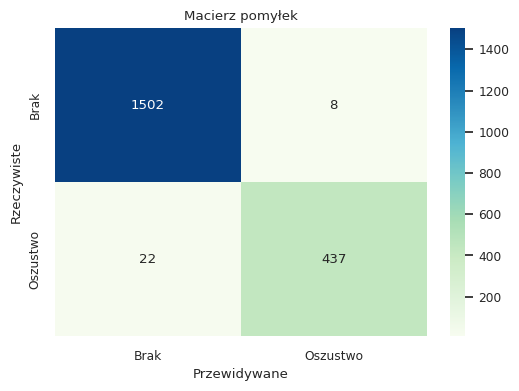

Wynik klasyfikacji:
+----------+------------+-----------+------------+
| Klasa    | Precyzja   | Czułość   |   F1-score |
+==========+============+===========+============+
|          |            |           |            |
+----------+------------+-----------+------------+
| Brak     | 0.99       | 0.99      |       1510 |
+----------+------------+-----------+------------+
| Oszustwo | 0.95       | 0.97      |        459 |
+----------+------------+-----------+------------+


In [45]:
y_pred = best_model.predict(X_test)
class_names = ['Brak', 'Oszustwo']
ConfusionMatrix(y_test, y_pred)
formatuj_macierz(y_test, y_pred)

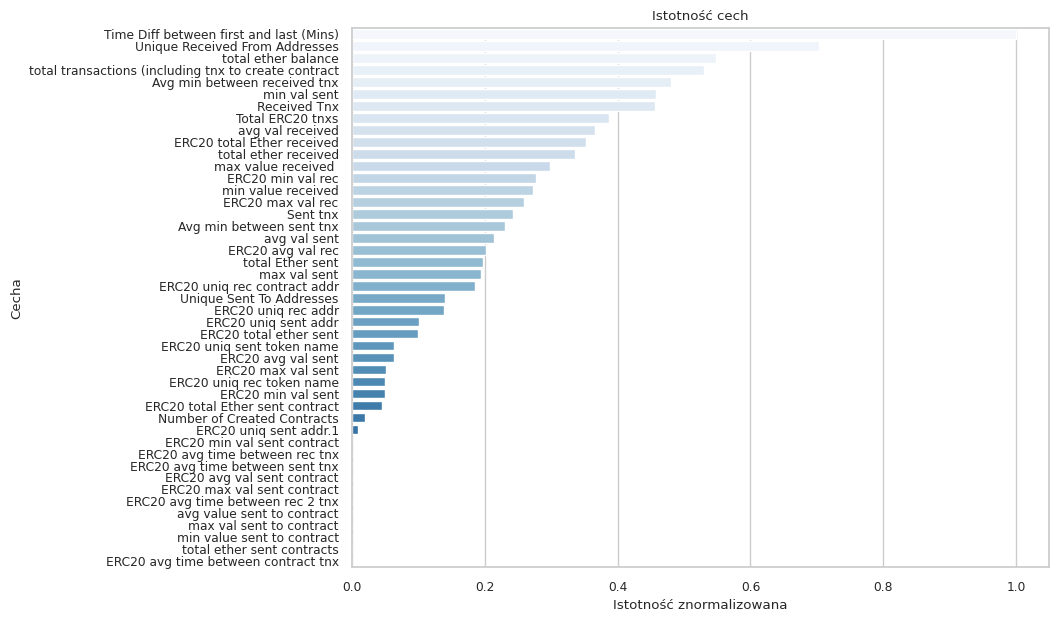

In [62]:
def istotnosc_cech(feature_importance):
    column_names = ds.drop(columns='FLAG').columns
    df_feature_importance = pd.DataFrame(sorted(zip(feature_importance, column_names)),
                                       columns=['istotnosc', 'cecha'])
    df_feature_importance['istotnosc_normalized'] = df_feature_importance['istotnosc'] / df_feature_importance['istotnosc'].max()  # Normalizacja do zakresu od 0 do 1
    df_feature_importance = df_feature_importance.sort_values('istotnosc_normalized', ascending=False)

    plt.figure(figsize=(9, 7)).tight_layout()
    sns.barplot(y="cecha", x="istotnosc_normalized", data=df_feature_importance,  palette = "Blues")
    plt.xlabel("Istotność znormalizowana")
    plt.ylabel("Cecha")
    plt.title("Istotność cech")
    plt.show()

istotnosc_cech(best_model.feature_importances_)
